## Import necessary libraries

In [1]:
import pandas as pd
import joblib
from google.colab import files
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor




# Load the dataset



In [2]:
uploaded = files.upload()


Saving yield_df.csv to yield_df.csv


In [3]:
df = pd.read_csv('yield_df.csv')

## Prepare and Save Original DataFrame for Streamlit

To allow the Streamlit app to display original historical data, we need to save the DataFrame in its state *before* one-hot encoding. This ensures the app can access the non-encoded `Area` and `Item` names along with the numerical features and actual yield.

In [4]:


# Create a copy of the DataFrame before one-hot encoding to preserve original categorical values
# This `df` state is after dropping 'Unnamed: 0' and duplicates, but before one-hot encoding.
original_df_for_streamlit = df.copy()

# Save this DataFrame
joblib.dump(original_df_for_streamlit, 'original_df_for_streamlit.pkl')

print("Original DataFrame (pre-one-hot encoding) saved as 'original_df_for_streamlit.pkl'!")

Original DataFrame (pre-one-hot encoding) saved as 'original_df_for_streamlit.pkl'!


# Initial Exploration of the dataset


In [5]:
# display the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# display first 5 rows of the dataframe to verify it has been loaded correctly
display(df.head())

# Display information about the DataFrame (like data types, non-null values, and etc.)
print("\nDataFrame Info:")
df.info()

# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
display(df.describe())

# Display descriptive statistics for categorical columns
print("\nDescriptive Statistics for Categorical Columns:")
display(df.describe(include='object'))

Shape of the DataFrame: (28242, 8)


,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB

Descriptive Statistics:


,Unnamed: 0,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,14120.500000,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,8152.907488,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,0.000000,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,7060.250000,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,14120.500000,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,21180.750000,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,28241.000000,2013.000000,501412.000000,3240.00000,367778.000000,30.650000



Descriptive Statistics for Categorical Columns:


,Area,Item
count,28242,28242
unique,101,10
top,India,Potatoes
freq,4048,4276


## Preprocess Dataset to get it ready for deeper exploratory analysis


In [6]:
# Drop the 'Unnamed: 0' column as it is likely an index
df = df.drop('Unnamed: 0', axis=1)

# Display the first few rows to confirm the column is dropped
display(df.head())

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [7]:
# Check for missing values in each column
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64


In [8]:
# identify for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# drop duplicate rows
df = df.drop_duplicates()
print(f"Number of rows after removing duplicates: {df.shape[0]}")

Number of duplicate rows: 2310
Number of rows after removing duplicates: 25932


# Deeper exploration of the dataset
Explore the dataset further by visualizing the distribution of numerical and categorical features, examining the relationships between features and the target variable, and analyzing correlations between numerical features.

## Visualize the distribution of numerical features




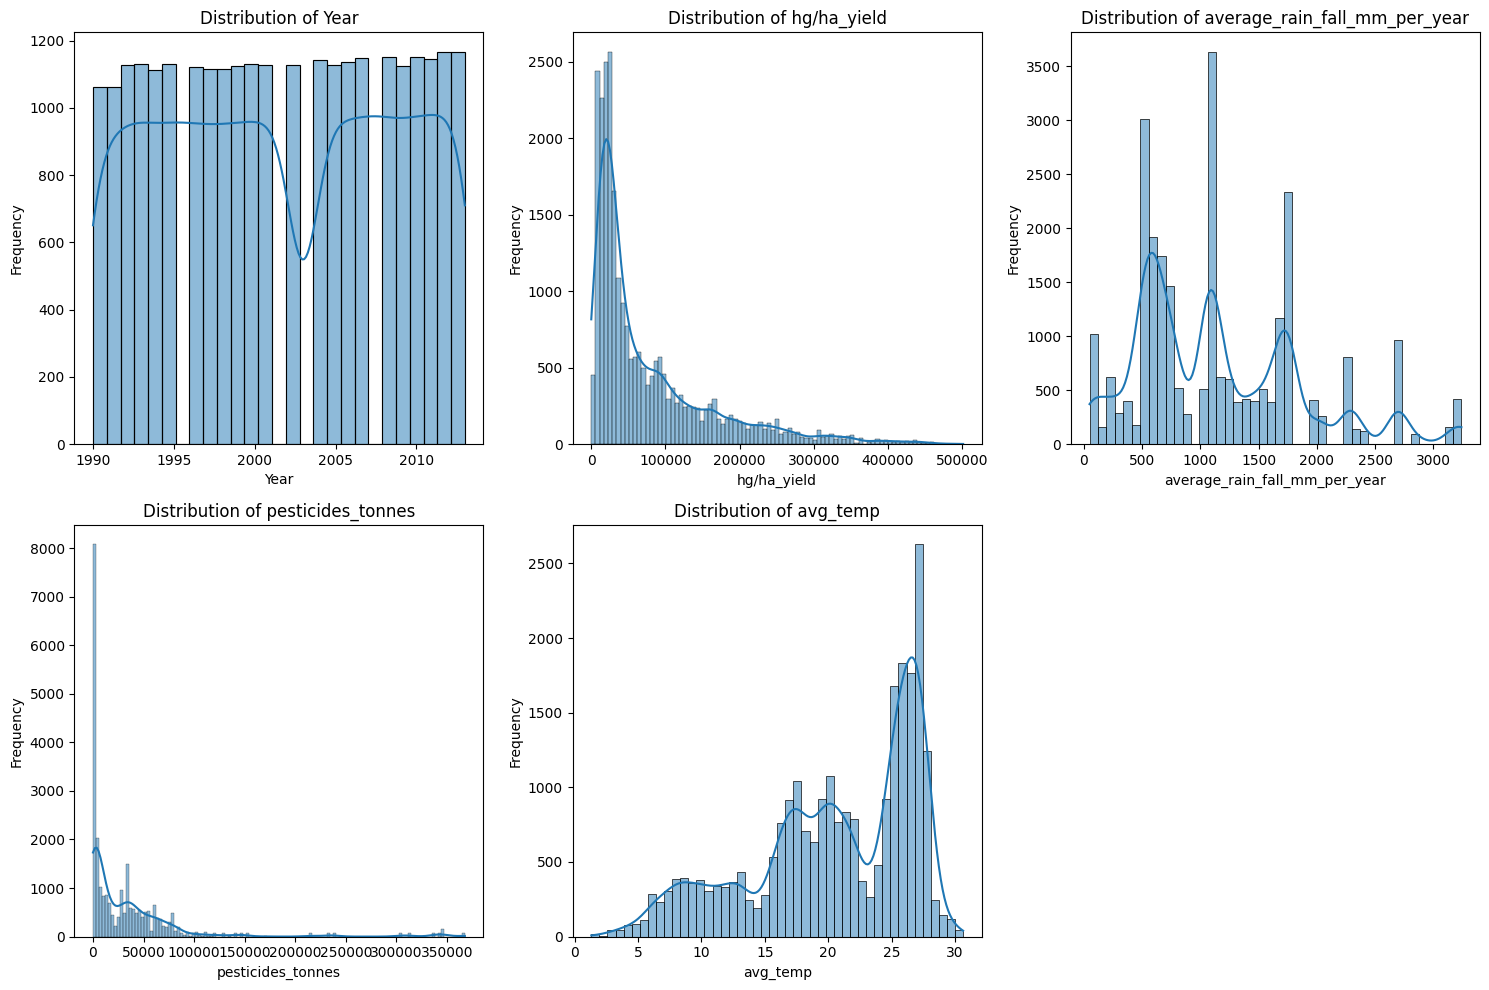

In [9]:
numerical_cols = ['Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Explore the relationship between numerical features and the target variable



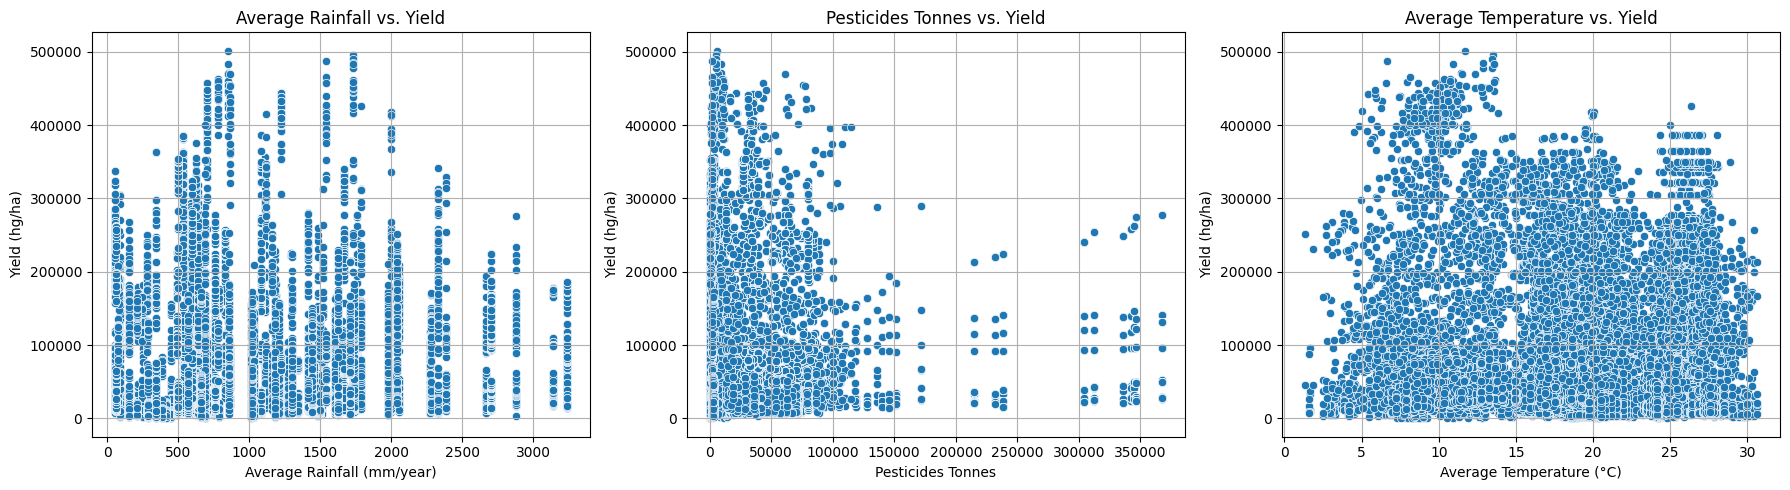

In [10]:
# create scatter plots for key environmental/management factors vs. yield
plt.figure(figsize=(18, 5))

# scatter plot: Average Rainfall vs. Yield
plt.subplot(1, 3, 1)
sns.scatterplot(x='average_rain_fall_mm_per_year', y='hg/ha_yield', data=df)
plt.title("Average Rainfall vs. Yield")
plt.xlabel("Average Rainfall (mm/year)")
plt.ylabel("Yield (hg/ha)")
plt.grid(True)

# scatter plot: Pesticides Tonnes vs. Yield
plt.subplot(1, 3, 2)
sns.scatterplot(x='pesticides_tonnes', y='hg/ha_yield', data=df)
plt.title("Pesticides Tonnes vs. Yield")
plt.xlabel("Pesticides Tonnes")
plt.ylabel("Yield (hg/ha)")
plt.grid(True)

# scatter plot: Average Temperature vs. Yield
plt.subplot(1, 3, 3)
sns.scatterplot(x='avg_temp', y='hg/ha_yield', data=df)
plt.title("Average Temperature vs. Yield")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Yield (hg/ha)")
plt.grid(True)

plt.tight_layout()
plt.show()

## Investigate the relationship between categorical features and the target variable




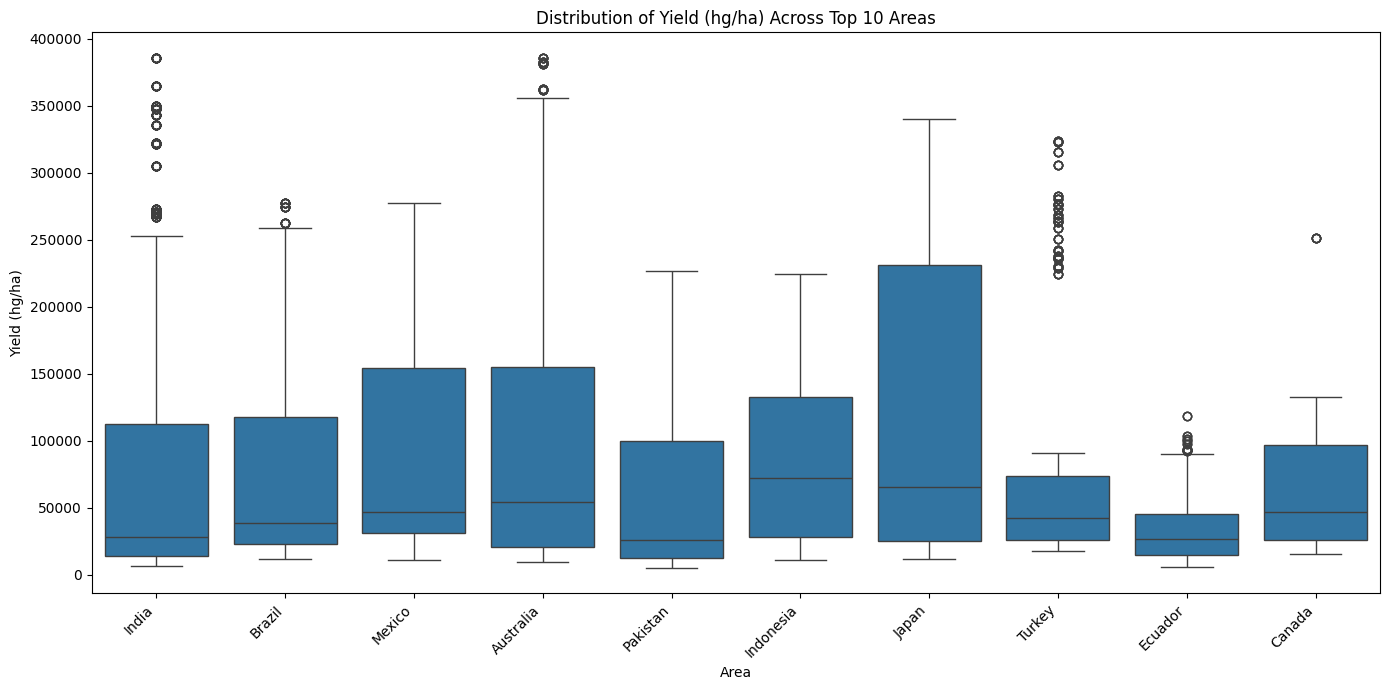

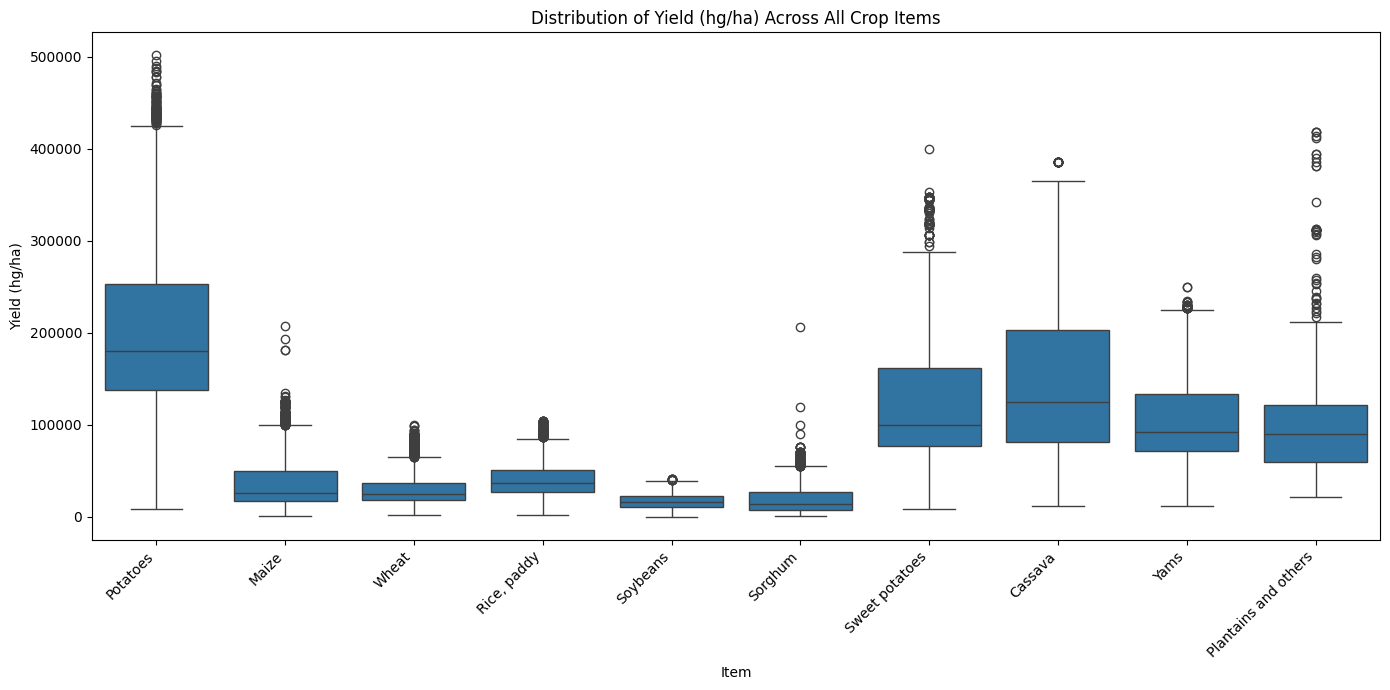

In [11]:
# identify the top 10 most frequent areas based on the 'Area' column's value counts.
top_10_areas = df['Area'].value_counts().nlargest(10).index.tolist()

# Filtere DataFrame to include only the top 10 areas
df_top_areas = df[df['Area'].isin(top_10_areas)]

#  box plot to visualize the distribution of 'hg/ha_yield' for the top 10 area.
plt.figure(figsize=(14, 7))
sns.boxplot(x='Area', y='hg/ha_yield', data=df_top_areas, order=top_10_areas)
plt.title('Distribution of Yield (hg/ha) Across Top 10 Areas')
plt.xlabel('Area')
plt.ylabel('Yield (hg/ha)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#  box plot to visualize the distribution of 'hg/ha_yield' for all unique 'Item' categories.
plt.figure(figsize=(14, 7))
sns.boxplot(x='Item', y='hg/ha_yield', data=df, order=df['Item'].value_counts().index)
plt.title('Distribution of Yield (hg/ha) Across All Crop Items')
plt.xlabel('Item')
plt.ylabel('Yield (hg/ha)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Explore correlations between numerical features



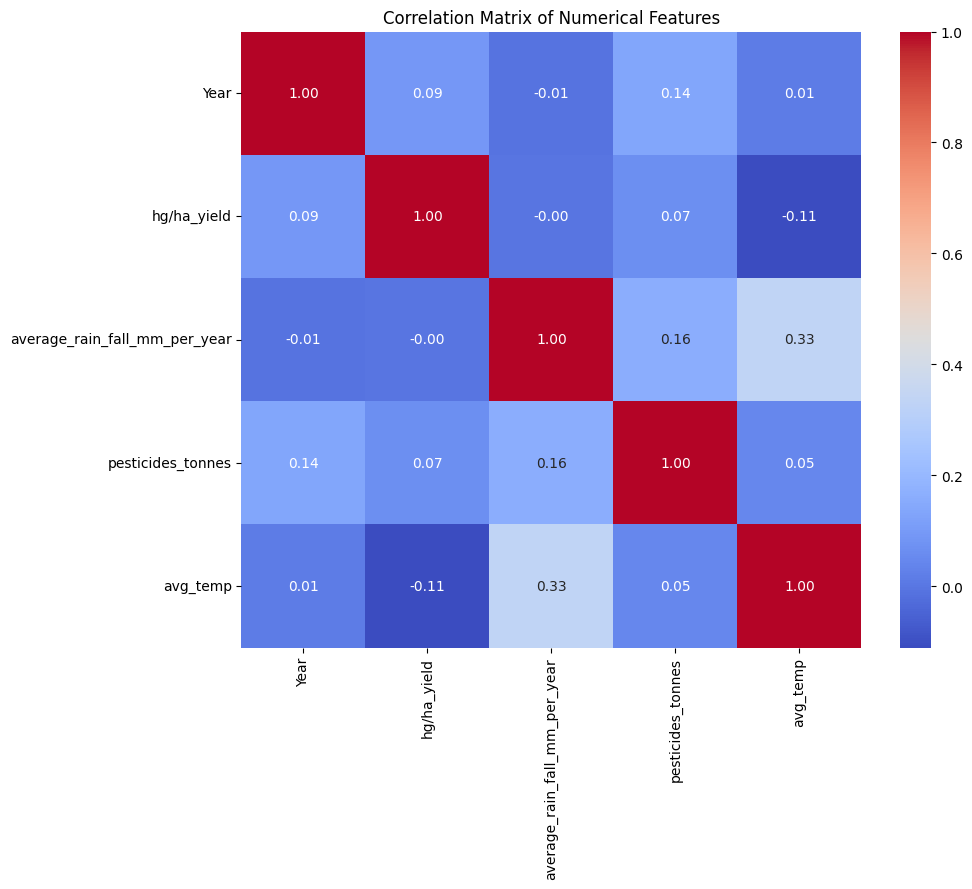

In [12]:
# select numerical columns
numerical_cols = ['Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
df_numerical = df[numerical_cols]

# clculate the correlation matrix
correlation_matrix = df_numerical.corr()

# make the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Encoding categorical variables


In [13]:
# Perform one-hot encoding for 'Area' and 'Item' columns
df = pd.get_dummies(df, columns=['Area', 'Item'], drop_first=False)

# Display the first few rows of the modified DataFrame to see the new columns
display(df.head())

# Display the shape of the DataFrame to see the increase in columns
print("\nShape of the DataFrame after one-hot encoding:", df.shape)

,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Area_Albania,Area_Algeria,Area_Angola,Area_Argentina,Area_Armenia,...,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
0,1990,36613,1485.0,121.0,16.37,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,1990,66667,1485.0,121.0,16.37,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,1990,23333,1485.0,121.0,16.37,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,1990,12500,1485.0,121.0,16.37,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,1990,7000,1485.0,121.0,16.37,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False



Shape of the DataFrame after one-hot encoding: (25932, 116)


### Split data



In [14]:
X = df.drop('hg/ha_yield', axis=1)
y = df['hg/ha_yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Model selection and evaluation

### Subtask:
Train and evaluate multiple models to compare their performance.


In [15]:
X = df.drop('hg/ha_yield', axis=1)
y = df['hg/ha_yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# make the columnsd aligned because crucial for consistent feature sets between train and test
train_cols = X_train.columns
test_cols = X_test.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train[c] = 0

X_test = X_test[train_cols] #  the order of columns is the same

# intiialize and train the models again
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(max_iter=10000), # Increased max_iter
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) # Calculate RMSE
    mae = mean_absolute_error(y_test, y_pred) # Calculate MAE
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R-squared": r2} # storage of all metrics
    print(f"{name} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R-squared: {r2:.2f}\n")

print("\nModel Evaluation Results:")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  MSE: {metrics['MSE']:.2f}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAE: {metrics['MAE']:.2f}")
    print(f"  R-squared: {metrics['R-squared']:.2f}")

Training Linear Regression...
Linear Regression - MSE: 1821712446.67, RMSE: 42681.52, MAE: 29920.74, R-squared: 0.75

Training Ridge Regression...
Ridge Regression - MSE: 1822603355.99, RMSE: 42691.96, MAE: 29885.34, R-squared: 0.75

Training Lasso Regression...
Lasso Regression - MSE: 1822131034.35, RMSE: 42686.43, MAE: 29905.95, R-squared: 0.75

Training Random Forest Regressor...
Random Forest Regressor - MSE: 113441158.55, RMSE: 10650.88, MAE: 4038.94, R-squared: 0.98

Training Gradient Boosting Regressor...
Gradient Boosting Regressor - MSE: 1002996227.51, RMSE: 31670.12, MAE: 20294.77, R-squared: 0.86


Model Evaluation Results:
Linear Regression:
  MSE: 1821712446.67
  RMSE: 42681.52
  MAE: 29920.74
  R-squared: 0.75
Ridge Regression:
  MSE: 1822603355.99
  RMSE: 42691.96
  MAE: 29885.34
  R-squared: 0.75
Lasso Regression:
  MSE: 1822131034.35
  RMSE: 42686.43
  MAE: 29905.95
  R-squared: 0.75
Random Forest Regressor:
  MSE: 113441158.55
  RMSE: 10650.88
  MAE: 4038.94
  R-squar

## Justify model choice

### stask:
Based on the evaluation, select the most appropriate model and justify the choice.


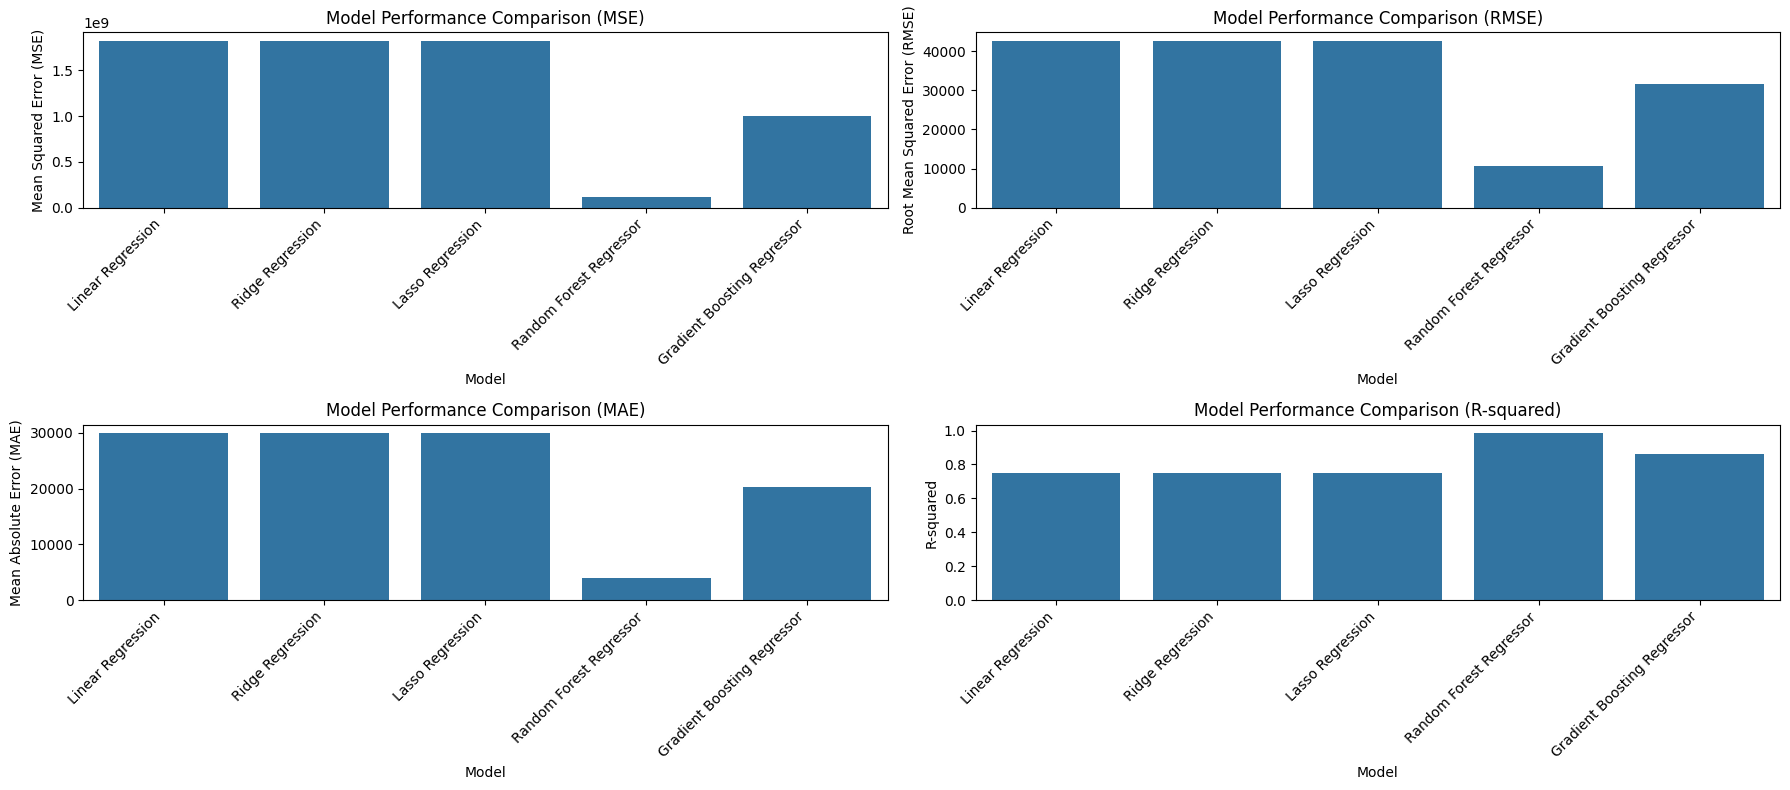

In [16]:
# convedrt results dictionary to a pandas DataFrame for easier plotting
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'Model'})

# make the DataFrame to have a single column for metrics (MSE, RMSE, MAE, and R-squared)
melted_results_df = results_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# create bar plots for MSE, RMSE, MAE and R-squared
plt.figure(figsize=(18, 8))

plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Value', data=melted_results_df[melted_results_df['Metric'] == 'MSE'])
plt.title('Model Performance Comparison (MSE)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Value', data=melted_results_df[melted_results_df['Metric'] == 'RMSE'])
plt.title('Model Performance Comparison (RMSE)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Value', data=melted_results_df[melted_results_df['Metric'] == 'MAE'])
plt.title('Model Performance Comparison (MAE)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Value', data=melted_results_df[melted_results_df['Metric'] == 'R-squared'])
plt.title('Model Performance Comparison (R-squared)')
plt.ylabel('R-squared')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


plt.show()

## K-fold cross validation

In [17]:
# instantiate KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    print(f"Performing cross-validation for {name}...")

    # cross-validation for MSE (negative)
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mean_mse = -mse_scores.mean() # Convert to positive MSE
    std_mse = mse_scores.std()

    # cross-validation for R-squared
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mean_r2 = r2_scores.mean()
    std_r2 = r2_scores.std()

    cv_results[name] = {
        "Mean MSE": mean_mse,
        "Std MSE": std_mse,
        "Mean R-squared": mean_r2,
        "Std R-squared": std_r2
    }

    print(f"{name} - Mean MSE: {mean_mse:.2f} (± {std_mse:.2f}), Mean R-squared: {mean_r2:.2f} (± {std_r2:.2f})\n")

print("\nCross-Validation Results:")
for name, metrics in cv_results.items():
    print(f"{name}:")
    print(f"  Mean MSE: {metrics['Mean MSE']:.2f} (± {metrics['Std MSE']:.2f})")
    print(f"  Mean R-squared: {metrics['Mean R-squared']:.2f} (± {metrics['Std R-squared']:.2f})")

Performing cross-validation for Linear Regression...
Linear Regression - Mean MSE: 1802752623.71 (± 40597903.00), Mean R-squared: 0.75 (± 0.00)

Performing cross-validation for Ridge Regression...
Ridge Regression - Mean MSE: 1802748654.54 (± 40731682.01), Mean R-squared: 0.75 (± 0.00)

Performing cross-validation for Lasso Regression...
Lasso Regression - Mean MSE: 1802736738.84 (± 40683871.26), Mean R-squared: 0.75 (± 0.00)

Performing cross-validation for Random Forest Regressor...
Random Forest Regressor - Mean MSE: 87466542.98 (± 16246370.78), Mean R-squared: 0.99 (± 0.00)

Performing cross-validation for Gradient Boosting Regressor...
Gradient Boosting Regressor - Mean MSE: 958885201.10 (± 35300056.58), Mean R-squared: 0.87 (± 0.01)


Cross-Validation Results:
Linear Regression:
  Mean MSE: 1802752623.71 (± 40597903.00)
  Mean R-squared: 0.75 (± 0.00)
Ridge Regression:
  Mean MSE: 1802748654.54 (± 40731682.01)
  Mean R-squared: 0.75 (± 0.00)
Lasso Regression:
  Mean MSE: 18027367

## Hyperparameter Tuning for Random Forest Regressor using GridSearchCV


Optimize the hyperparameters of the Random Forest Regressor using GridSearchCV.

In [18]:
# define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],  # Reduced number of trees
    'max_depth': [10, 20],      # Reduced options for max depth
    'min_samples_split': [2, 5],  # Reduced options for min samples split
    'min_samples_leaf': [1, 2]     # Reduced options for min samples leaf
}

# initialize GridSearchCV
# using the Random Forest Regressor
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,       # reduced cross-validation folds for faster execution
                           scoring='neg_mean_squared_error', # score using negative MSE
                           n_jobs=-1)   # Use all available CPU cores

print("Performing GridSearchCV for Random Forest Regressor...")

#  the grid search on the training data
grid_search.fit(X_train, y_train)

print("GridSearchCV complete.")

#  the best parameters found
print("\nBest parameters found: ", grid_search.best_params_)

#  the best cross-validation score (negative MSE)
print("\nBest cross-validation score (negative MSE): ", grid_search.best_score_)

#  the best estimator (the trained model with the best parameters)
best_rf_model_tuned = grid_search.best_estimator_

# evaluate the best tuned model on the test set
y_pred_best_rf_tuned = best_rf_model_tuned.predict(X_test)
mse_best_rf_tuned = mean_squared_error(y_test, y_pred_best_rf_tuned)
rmse_best_rf_tuned = np.sqrt(mse_best_rf_tuned)
mae_best_rf_tuned = mean_absolute_error(y_test, y_pred_best_rf_tuned)
r2_best_rf_tuned = r2_score(y_test, y_pred_best_rf_tuned)

print("\nEvaluation of the best tuned Random Forest model on the test set:")
print(f"  MSE: {mse_best_rf_tuned:.2f}")
print(f"  RMSE: {rmse_best_rf_tuned:.2f}")
print(f"  MAE: {mae_best_rf_tuned:.2f}")
print(f"  R-squared: {r2_best_rf_tuned:.2f}")

Performing GridSearchCV for Random Forest Regressor...
GridSearchCV complete.

Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best cross-validation score (negative MSE):  -123094351.84553295

Evaluation of the best tuned Random Forest model on the test set:
  MSE: 126923586.95
  RMSE: 11266.04
  MAE: 4693.75
  R-squared: 0.98


In [19]:

best_model = best_rf_model_tuned


area_cols = [col for col in X_train.columns if col.startswith('Area_')]
item_cols = [col for col in X_train.columns if col.startswith('Item_')]


area_results = {}
item_results = {}


print("Best tuned model selected for potential further analysis:", type(best_model).__name__)



Best tuned model selected for potential further analysis: RandomForestRegressor


## Best Model Performance Metrics

## Visualization of Untuned vs. Tuned Random Forest Regressor Performance



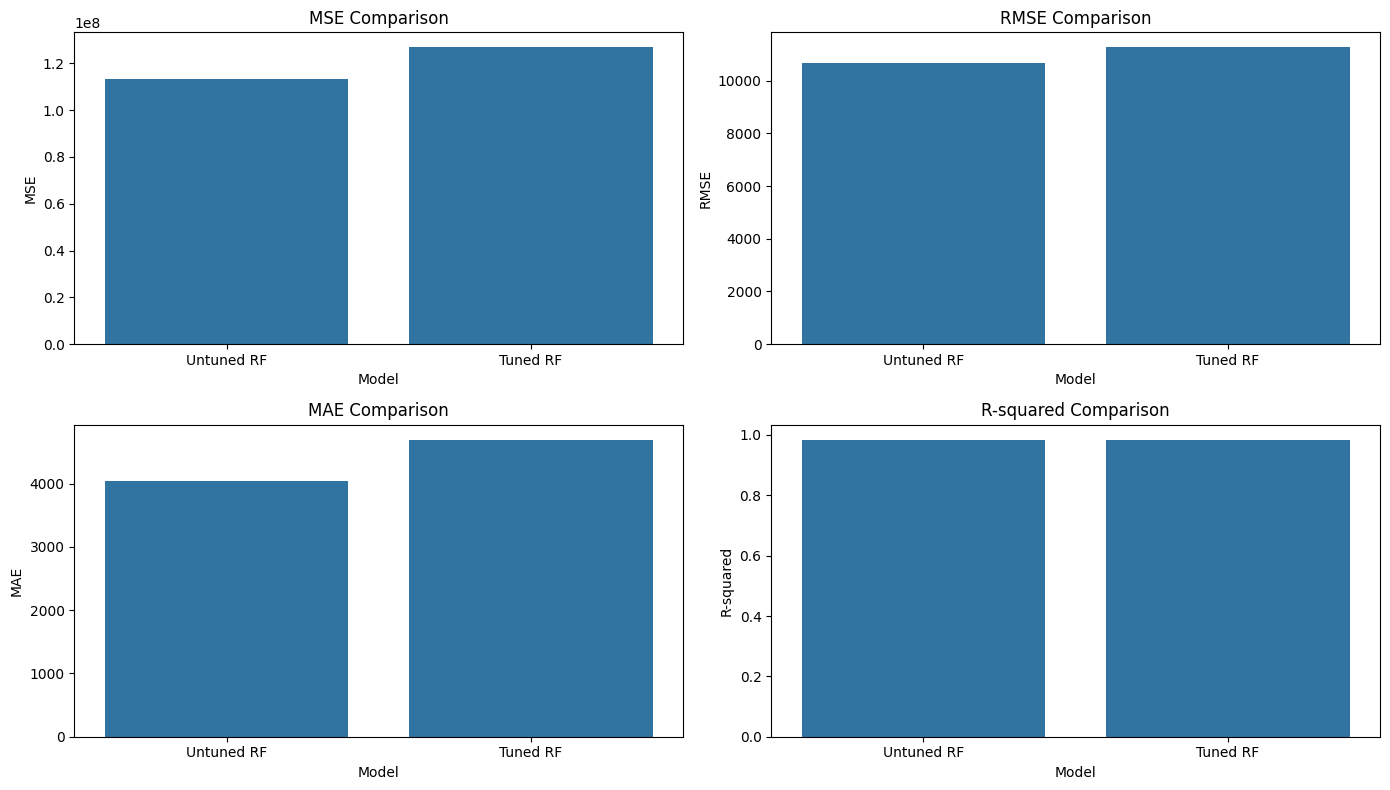

In [20]:
#  the performance metrics for the untuned Random Forest Regressor

untuned_rf_metrics = results["Random Forest Regressor"]

# the performance metrics for the tuned Random Forest Regressor

tuned_rf_metrics = {
    "MSE": mse_best_rf_tuned,
    "RMSE": rmse_best_rf_tuned,
    "MAE": mae_best_rf_tuned,
    "R-squared": r2_best_rf_tuned
}

# Prepare data for plotting
metrics_data = {
    "Metric": ["MSE", "RMSE", "MAE", "R-squared"] * 2,
    "Value": [
        untuned_rf_metrics["MSE"], untuned_rf_metrics["RMSE"], untuned_rf_metrics["MAE"], untuned_rf_metrics["R-squared"],
        tuned_rf_metrics["MSE"], tuned_rf_metrics["RMSE"], tuned_rf_metrics["MAE"], tuned_rf_metrics["R-squared"]
    ],
    "Model": ["Untuned RF"] * 4 + ["Tuned RF"] * 4
}

metrics_df = pd.DataFrame(metrics_data)

# Create bar plots for each metric
plt.figure(figsize=(14, 8))

# Plot MSE
plt.subplot(2, 2, 1)
sns.barplot(x="Model", y="Value", data=metrics_df[metrics_df["Metric"] == "MSE"])
plt.title("MSE Comparison")
plt.ylabel("MSE")

# Plot RMSE
plt.subplot(2, 2, 2)
sns.barplot(x="Model", y="Value", data=metrics_df[metrics_df["Metric"] == "RMSE"])
plt.title("RMSE Comparison")
plt.ylabel("RMSE")

# Plot MAE
plt.subplot(2, 2, 3)
sns.barplot(x="Model", y="Value", data=metrics_df[metrics_df["Metric"] == "MAE"])
plt.title("MAE Comparison")
plt.ylabel("MAE")

# Plot R-squared
plt.subplot(2, 2, 4)
sns.barplot(x="Model", y="Value", data=metrics_df[metrics_df["Metric"] == "R-squared"])
plt.title("R-squared Comparison")
plt.ylabel("R-squared")

plt.tight_layout()
plt.show()

## Actual vs Predicted Crop Yield

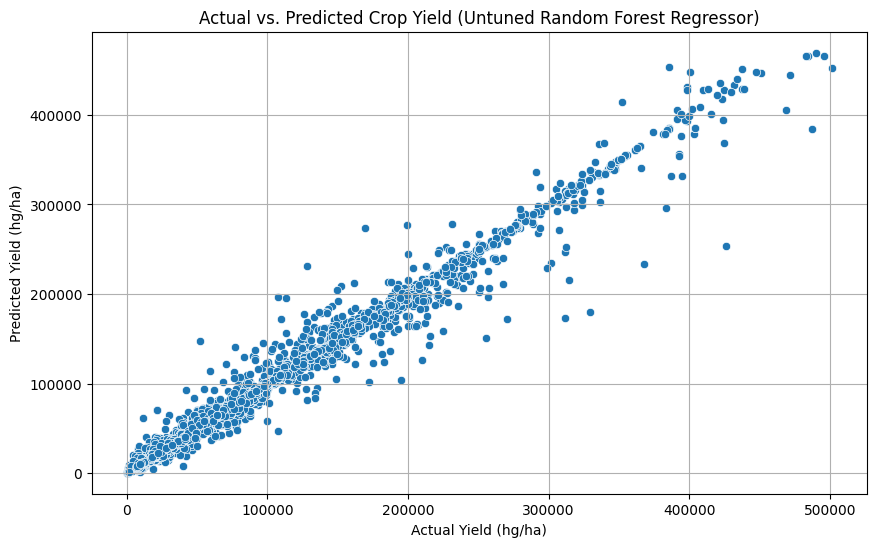

In [21]:
# get the best performing model (Random Forest Regressor)
# use the untuned Random Forest model for comparison
best_model = models["Random Forest Regressor"]

# make predictions on the test set
y_pred_best_model = best_model.predict(X_test)

# scatter plot of Actual vs. Predicted Yield
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best_model)
plt.xlabel("Actual Yield (hg/ha)")
plt.ylabel("Predicted Yield (hg/ha)")
plt.title("Actual vs. Predicted Crop Yield (Untuned Random Forest Regressor)")
plt.grid(True)
plt.show()

In [22]:
# Load the original_df_for_streamlit for per-crop mean calculation
# This DataFrame retains the original 'Item' column before one-hot encoding.
original_df_for_streamlit = joblib.load('original_df_for_streamlit.pkl')
print("original_df_for_streamlit loaded for per-crop mean calculation.")

# Calculate the mean yield for each crop ('Item') using the original_df_for_streamlit
per_crop_mean_yield = original_df_for_streamlit.groupby('Item')['hg/ha_yield'].mean().to_dict()

# Save the dictionary of per-crop mean yields
joblib.dump(per_crop_mean_yield, 'per_crop_mean_yield.pkl')

print("Per-crop mean yield calculated and saved as 'per_crop_mean_yield.pkl'!")

original_df_for_streamlit loaded for per-crop mean calculation.
Per-crop mean yield calculated and saved as 'per_crop_mean_yield.pkl'!


## Mean Historical Yield per Crop Visualization

This graph displays the average historical yield for each crop type present in the dataset, providing a quick comparison of productivity across different items.

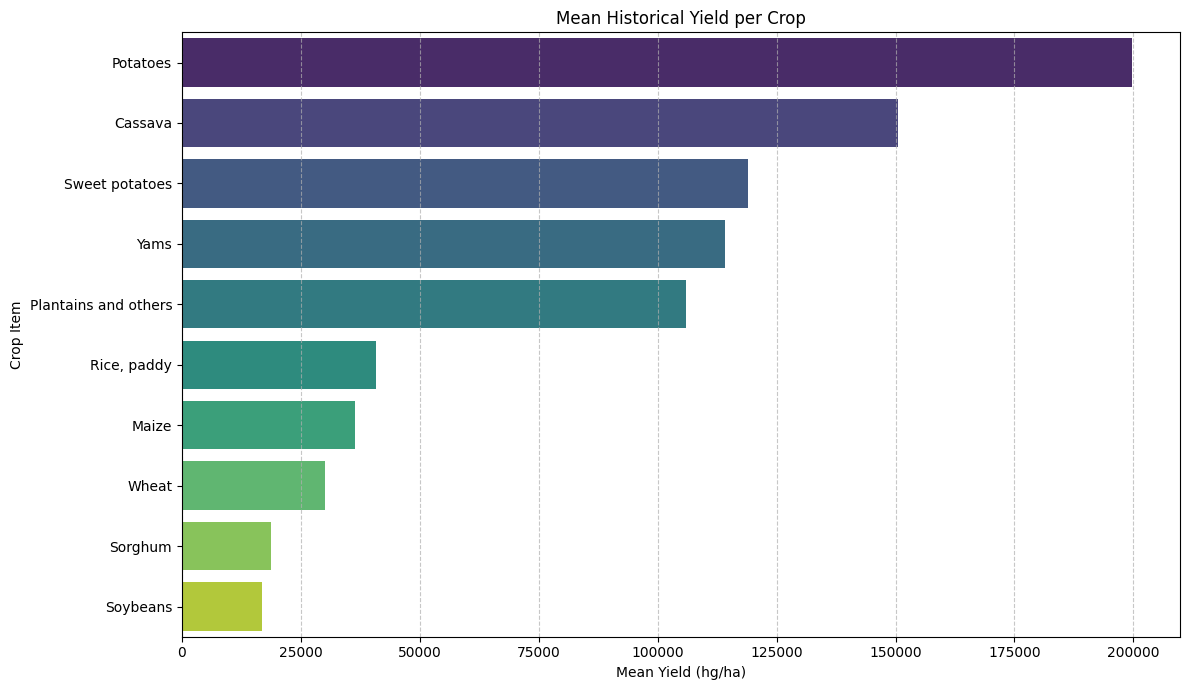

In [23]:
# Load the per_crop_mean_yield dictionary
# Ensure 'per_crop_mean_yield.pkl' has been created and saved previously
per_crop_mean_yield = joblib.load('per_crop_mean_yield.pkl')


# Convert the dictionary to a DataFrame for easier plotting
yield_df = pd.DataFrame(list(per_crop_mean_yield.items()), columns=['Crop', 'Mean Yield (hg/ha)'])

# Sort for better visualization
yield_df = yield_df.sort_values(by='Mean Yield (hg/ha)', ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Mean Yield (hg/ha)', y='Crop', data=yield_df, palette='viridis', hue='Crop', legend=False)
plt.title('Mean Historical Yield per Crop')
plt.xlabel('Mean Yield (hg/ha)')
plt.ylabel('Crop Item')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Residual plot

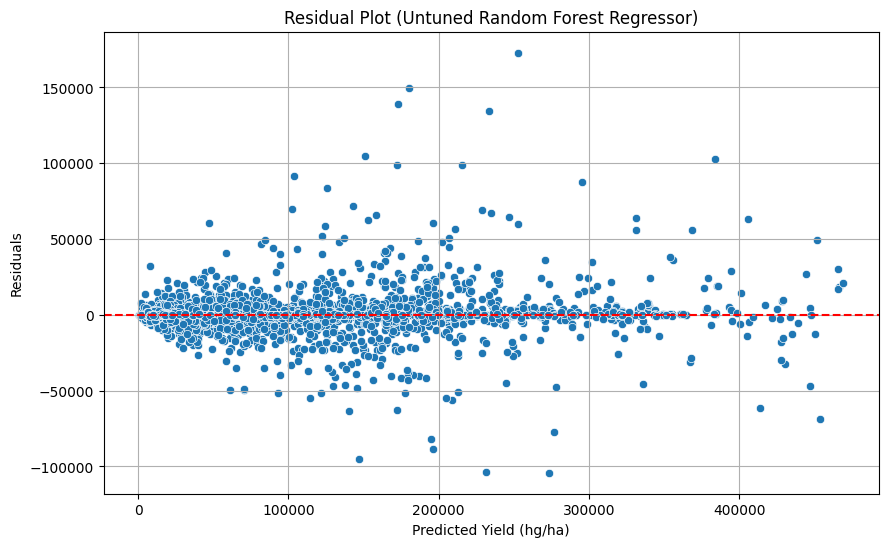

In [24]:
# get the best performing model (Random Forest Regressor)
# use the untuned Random Forest model for comparison
best_model = models["Random Forest Regressor"]

# make predictions on the test set
y_pred_best_model = best_model.predict(X_test)

# calculate residuals
residuals = y_test - y_pred_best_model

# residual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best_model, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Yield (hg/ha)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Untuned Random Forest Regressor)")
plt.grid(True)
plt.show()

## Feature Importance

,Feature,Importance
108,Item_Potatoes,0.372160
105,Item_Cassava,0.091256
112,Item_Sweet potatoes,0.085761
2,pesticides_tonnes,0.072765
46,Area_India,0.057212
1,average_rain_fall_mm_per_year,0.044770
3,avg_temp,0.042768
0,Year,0.034164
114,Item_Yams,0.024424
52,Area_Japan,0.017789


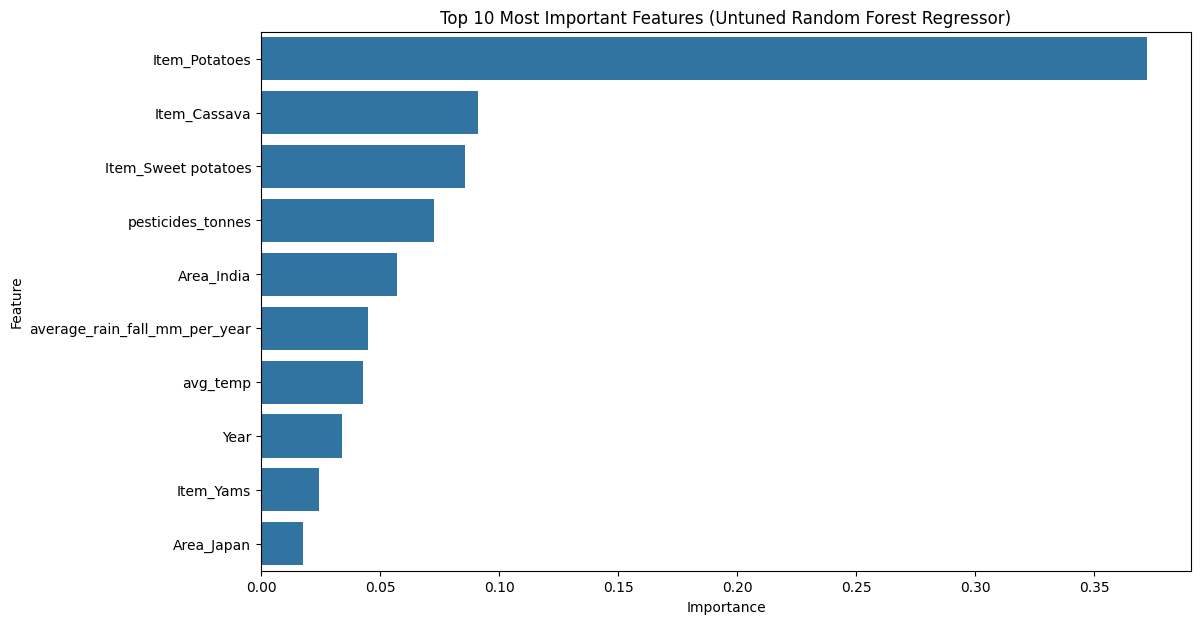

In [25]:
# Get the best performing model (Random Forest Regressor)
# use the untuned Random Forest model for comparison
best_model = models["Random Forest Regressor"]

# get feature importances
# feature importances should be from the untuned model
feature_importances = best_model.feature_importances_

# create a DataFrame for better visualization
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
display(features_df.head(10))

# Plot feature importances (top 10)
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=features_df.head(10))
plt.title("Top 10 Most Important Features (Untuned Random Forest Regressor)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## Save best trained model to prep Streamlit deployment


In [26]:
# Save the best trained model
joblib.dump(best_rf_model_tuned, 'best_rf_model_tuned.pkl')

# Also save the list of columns from the training data
# This is crucial for ensuring the Streamlit app receives inputs in the correct format
joblib.dump(X_train.columns, 'training_columns.pkl')

# Save feature importances for visualization in Streamlit app
joblib.dump(features_df, 'feature_importances.pkl')

# Save mean and standard deviation of y_train for contextual plots
joblib.dump(y_train.mean(), 'y_train_mean.pkl')
joblib.dump(y_train.std(), 'y_train_std.pkl')

print("Tuned Random Forest model, training columns, feature importances, and y_train stats saved successfully!")

Tuned Random Forest model, training columns, feature importances, and y_train stats saved successfully!


## requirements file for Streamlit App


In [27]:
%%writefile requirements.txt
pandas
scikit-learn
streamlit
matplotlib
seaborn
numpy

Writing requirements.txt


## Code for Streamlit App


In [28]:
%%writefile streamlit_app.py
import streamlit as st


st.set_page_config(layout='wide')

st.title('Crop Yield Prediction App')
st.write('Predict crop yield based on environmental factors and crop types.')

# Load the trained model and training columns
@st.cache_resource
def load_data():
    model = joblib.load('best_rf_model_tuned.pkl')
    training_columns = joblib.load('training_columns.pkl')
    feature_importances_df = joblib.load('feature_importances.pkl')
    per_crop_mean_yield = joblib.load('per_crop_mean_yield.pkl')
    original_df = joblib.load('original_df_for_streamlit.pkl') # Load original df
    return model, training_columns, feature_importances_df, per_crop_mean_yield, original_df

model, training_columns, feature_importances_df, per_crop_mean_yield, original_df = load_data()

# Extract unique Area and Item names from training_columns for select boxes
all_areas = sorted([col.replace('Area_', '') for col in training_columns if col.startswith('Area_')])
all_items = sorted([col.replace('Item_', '') for col in training_columns if col.startswith('Item_')])

# Sidebar for user input
st.sidebar.header('Input Features')

# User inputs
selected_area = st.sidebar.selectbox('Area', all_areas)
selected_item = st.sidebar.selectbox('Item', all_items)

year = st.sidebar.slider('Year', min_value=1990, max_value=2013, value=2010) # Adjusted max_value to 2013
rain_fall = st.sidebar.number_input('Average Rainfall (mm/year)', min_value=0.0, max_value=20000.0, value=1500.0)
pesticides = st.sidebar.number_input('Pesticides (tonnes)', min_value=0.0, max_value=100000.0, value=5000.0)
temperature = st.sidebar.number_input('Average Temperature (°C)', min_value=-20.0, max_value=40.0, value=20.0)


if st.sidebar.button('Predict Yield'):
    # Create a DataFrame for the current input, matching the structure of X_train
    input_data = pd.DataFrame(0, index=[0], columns=training_columns)

    # Populate numerical features
    input_data['Year'] = year
    input_data['average_rain_fall_mm_per_year'] = rain_fall
    input_data['pesticides_tonnes'] = pesticides
    input_data['avg_temp'] = temperature

    # Populate one-hot encoded categorical features
    if f'Area_{selected_area}' in input_data.columns:
        input_data[f'Area_{selected_area}'] = 1
    if f'Item_{selected_item}' in input_data.columns:
        input_data[f'Item_{selected_item}'] = 1

    # Ensure the order of columns is the same as during training
    input_data = input_data[training_columns]

    # Make prediction
    prediction = model.predict(input_data)[0]

    st.subheader('Prediction Result')

    # Display prediction prominently
    col1, col2 = st.columns([1, 2])
    with col1:
        st.metric("Predicted Yield", f"{prediction:,.2f} hg/ha")
    with col2:
        # Get historical mean for the selected crop
        historical_yield_for_item = per_crop_mean_yield.get(selected_item, 0) # Use .get with default 0 if item not found

        # --- New: Find and display historical data for comparison ---
        historical_record = original_df[
            (original_df['Area'] == selected_area) &
            (original_df['Item'] == selected_item) &
            (original_df['Year'] == year)
        ]

        plot_labels = ['Predicted', f'Avg Historical ({selected_item})']
        plot_values = [prediction, historical_yield_for_item]

        if not historical_record.empty:
            actual_yield = historical_record['hg/ha_yield'].iloc[0]
            historical_rain = historical_record['average_rain_fall_mm_per_year'].iloc[0]
            historical_pesticides = historical_record['pesticides_tonnes'].iloc[0]
            historical_temp = historical_record['avg_temp'].iloc[0]

            st.markdown(f"**Historical Data for {selected_item} in {selected_area} ({year}):**")
            st.write(f"- **Actual Yield:** {actual_yield:,.2f} hg/ha")
            st.write(f"- **Rainfall:** {historical_rain:,.2f} mm/year")
            st.write(f"- **Pesticides:** {historical_pesticides:,.2f} tonnes")
            st.write(f"- **Temperature:** {historical_temp:,.2f} °C")
            st.markdown("--- ")

            plot_labels.insert(1, 'Actual')
            plot_values.insert(1, actual_yield)

        else:
            st.info(f"No exact historical record found for {selected_item} in {selected_area} for {year}. Displaying predicted vs. average historical.")

        # Contextual plot: Predicted vs. Actual vs. Average Historical Yield
        fig_pred_vs_avg, ax_pred_vs_avg = plt.subplots(figsize=(6, 3))
        bars = ax_pred_vs_avg.bar(plot_labels, plot_values, color=['skyblue', 'lightgreen', 'lightgray'][:len(plot_labels)])
        ax_pred_vs_avg.set_ylabel('Yield (hg/ha)')
        ax_pred_vs_avg.set_title(f'Yield Comparison for {selected_item}')
        for bar in bars:
            yval = bar.get_height()
            ax_pred_vs_avg.text(bar.get_x() + bar.get_width()/2, yval + 500, round(yval, 0), ha='center', va='bottom', fontsize=8)
        st.pyplot(fig_pred_vs_avg)

    st.markdown("--- ")

# General Model Insights (Feature Importance)
st.subheader('Model Insights: Feature Importance')
with st.expander("View Feature Importance", expanded=False):
    fig_feature_imp, ax_feature_imp = plt.subplots(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(10), ax=ax_feature_imp)
    ax_feature_imp.set_title("Top 10 Most Important Features")
    ax_feature_imp.set_xlabel("Importance")
    ax_feature_imp.set_ylabel("Feature")
    st.pyplot(fig_feature_imp)

Writing streamlit_app.py
